# LSTM Time Series Example

> Note: This tutorial is based on [Time Series Forecasting with the Long Short-Term Memory Network in Python](http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/) by Jason Brownlee.


## Part 2 - Train LSTM 

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


# Load Data

Unlike part 1, this example includes additional training features.  These include the US unemployment rate and weather data for a yellowstone weather station.

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

dataset = read_csv('../data/yellowstone-visitors-ur-weather.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP
month,,,,,,
1990-01-01,25884,5.4,44,-5,26.9,8.8
1990-02-01,33285,5.3,50,-14,23.3,6.3
1990-03-01,19372,5.2,56,2,32.6,2.9
1990-04-01,29242,5.4,68,11,40.2,5.4
1990-05-01,203712,5.4,67,12,41.8,4.0


## Convert to Stationary Data

Like the visitors, the weather contains seasonal trends. We'll convert all the values to the change over the last month.

In [3]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

diff_values = difference(dataset.values)
diff_df = DataFrame(diff_values, columns=dataset.columns.values)
diff_df.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP
0,7401.0,-0.1,6.0,-9.0,-3.6,-2.5
1,-13913.0,-0.1,6.0,16.0,9.3,-3.4
2,9870.0,0.2,12.0,9.0,7.6,2.5
3,174470.0,0.0,-1.0,1.0,1.6,-1.4
4,322874.0,-0.2,20.0,19.0,12.9,-2.3


## Label Data

The label is the proceeding month's change in visitors.  This makes the training set a superived training set.

In [4]:
labels = diff_df['visitors'].rename(index='label')
shifted = diff_df.shift(1)
supervised = concat([shifted, labels], axis=1)
supervised.fillna(0, inplace=True)
supervised.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP,label
0,0.0,0.0,0.0,0.0,0.0,0.0,7401.0
1,7401.0,-0.1,6.0,-9.0,-3.6,-2.5,-13913.0
2,-13913.0,-0.1,6.0,16.0,9.3,-3.4,9870.0
3,9870.0,0.2,12.0,9.0,7.6,2.5,174470.0
4,174470.0,0.0,-1.0,1.0,1.6,-1.4,322874.0


## Split Training & Test Datasets

This step also scales the values between -1 and 1.

In [5]:
supervised_values = supervised.values
train, test = supervised_values[0:-12], supervised_values[-12:]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)

test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)

print('training set shape: {}'.format(train_scaled.shape))
print(train_scaled[0])

training set shape: (311, 7)
[  6.90947787e-02  -8.88178420e-16   1.60000000e-01   1.09703800e-03
   5.91133005e-02  -1.14754098e-01   8.45981350e-02]


## Define the Model

This network defines a statefule LSTM layer.  

In [6]:
batch_size = 1 # required for stateful LSTM
neurons = 20 
features = 6
labels = 1

model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, 1, features), stateful=True))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Train the Model

> Note: Stateful models update gradients for previous batches.  Get a cup of coffee... 

In [7]:
nb_epoch = 300

X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
for i in range(nb_epoch):
    if(i % 50 == 0):
        print(i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

0
50
100
150
200
250


## Create Predictions

We'll need to invert the scaling plus convert to absoult values.

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [9]:
visitor_history = dataset['visitors'].values

predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    X = X.reshape(1, 1, len(X))
    scaled_pred = model.predict(X, batch_size=batch_size)
    
    visitor_delta = invert_scale(scaler, X[0,0], scaled_pred[0,0])
    prev_mon_vistitor = visitor_history[-len(test_scaled)+1-i]
    
    pred = prev_mon_vistitor + visitor_delta
    expected = visitor_history[len(test_scaled) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, pred, expected))
    
    predictions.append(pred)

Month=1, Predicted=55592.868695, Expected=38050.000000
Month=2, Predicted=77355.242830, Expected=19946.000000
Month=3, Predicted=81872.236391, Expected=19875.000000
Month=4, Predicted=111904.738593, Expected=188798.000000
Month=5, Predicted=348332.245299, Expected=499107.000000
Month=6, Predicted=1030267.057468, Expected=796656.000000
Month=7, Predicted=1021818.777622, Expected=721103.000000
Month=8, Predicted=1012361.974585, Expected=432948.000000
Month=9, Predicted=554828.399172, Expected=144944.000000
Month=10, Predicted=186265.133682, Expected=6261.000000
Month=11, Predicted=-120120.027523, Expected=23998.000000
Month=12, Predicted=10084.106778, Expected=33552.000000


Let's plot the results...

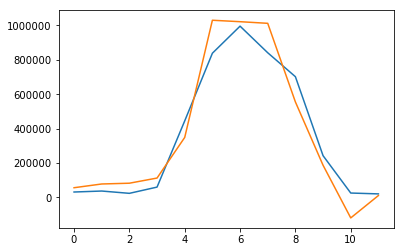

In [10]:
pyplot.plot(visitor_history[-12:])
pyplot.plot(predictions)
pyplot.show()

Did the LSTM work any better than the simple monthly average?

In [11]:
rmse = sqrt(mean_squared_error(visitor_history[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 104266.420
